# 04 - So sánh với Scikit-learn Logistic Regression và SMOTE

## 1. Cài đặt Thư viện

Bước đầu tiên là cài đặt các thư viện cần thiết, bao gồm `imbalanced-learn` để sử dụng SMOTE.

## 2. Tải Dữ liệu và Chuẩn bị

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Tải dữ liệu đã xử lý
train_df = pd.read_csv('../data/processed/aug_train_processed.csv')
test_df = pd.read_csv('../data/processed/aug_test_processed.csv')

print("Tải dữ liệu thành công.")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Tải dữ liệu thành công.
Train shape: (19098, 30)
Test shape: (2129, 29)


## 3. Xử lý Mất cân bằng với SMOTE

Tách dữ liệu và áp dụng SMOTE **chỉ trên tập huấn luyện** để tạo ra các mẫu dữ liệu tổng hợp cho lớp thiểu số, giúp cân bằng bộ dữ liệu.

In [6]:
# Tách features (X) và target (y)
X = train_df.drop('target', axis=1)
y = train_df['target']

# Chia dữ liệu: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Kích thước trước khi SMOTE: X_train shape={X_train.shape}")
print(f"Tỷ lệ lớp 1 ban đầu trong y_train: {y_train.mean():.2f}")

# Áp dụng SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Kích thước sau khi SMOTE: X_train shape={X_train_smote.shape}")
print(f"Tỷ lệ lớp 1 sau đó trong y_train_smote: {y_train_smote.mean():.2f}")

Kích thước trước khi SMOTE: X_train shape=(15278, 29)
Tỷ lệ lớp 1 ban đầu trong y_train: 0.25
Kích thước sau khi SMOTE: X_train shape=(22938, 29)
Tỷ lệ lớp 1 sau đó trong y_train_smote: 0.50


## 4. Huấn luyện Model `LogisticRegression`

Chúng ta sẽ huấn luyện một mô hình `LogisticRegression` từ thư viện `scikit-learn` trên dữ liệu đã được xử lý bằng SMOTE.

In [7]:
# Khởi tạo và huấn luyện model
lr_clf = LogisticRegression(n_jobs=-1, max_iter=1000)

print("Bắt đầu huấn luyện scikit-learn Logistic Regression...")
lr_clf.fit(X_train_smote, y_train_smote)
print("Huấn luyện hoàn tất.")

Bắt đầu huấn luyện scikit-learn Logistic Regression...
Huấn luyện hoàn tất.


/home/trungminh/miniconda3/envs/temp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5. Đánh giá Model

Chúng ta sẽ đánh giá hiệu suất của mô hình trên cả tập train (đã SMOTE) và validation (dữ liệu gốc, không cân bằng) để có cái nhìn toàn diện.

--- Đánh giá trên tập HUẤN LUYỆN (đã SMOTE) ---
              precision    recall  f1-score   support

           0       0.75      0.87      0.81     11469
           1       0.84      0.72      0.78     11469

    accuracy                           0.79     22938
   macro avg       0.80      0.79      0.79     22938
weighted avg       0.80      0.79      0.79     22938


--- Đánh giá trên tập XÁC THỰC ---
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2868
           1       0.49      0.39      0.44       952

    accuracy                           0.75      3820
   macro avg       0.65      0.63      0.64      3820
weighted avg       0.73      0.75      0.74      3820



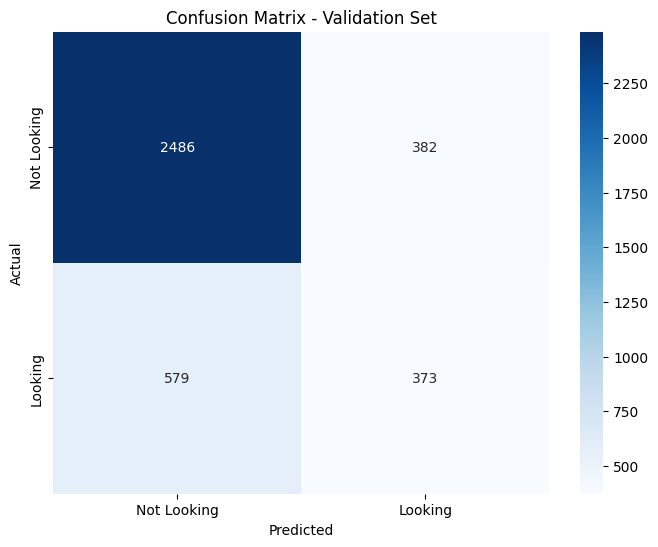

In [8]:
def evaluate_and_print(model, X_train, y_train, X_val, y_val):
    # Dự đoán trên tập train
    y_pred_train = model.predict(X_train)
    print("--- Đánh giá trên tập HUẤN LUYỆN (đã SMOTE) ---")
    print(classification_report(y_train, y_pred_train))

    # Dự đoán trên tập validation
    y_pred_val = model.predict(X_val)
    print("\n--- Đánh giá trên tập XÁC THỰC ---")
    print(classification_report(y_val, y_pred_val))

    # Vẽ ma trận nhầm lẫn (Confusion Matrix)
    cm = confusion_matrix(y_val, y_pred_val)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Looking', 'Looking'],
                yticklabels=['Not Looking', 'Looking'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()

evaluate_and_print(lr_clf, X_train_smote, y_train_smote, X_val, y_val)

## 6. Kết luận Baseline

Kết quả này từ một thư viện tiêu chuẩn như `scikit-learn` cùng với SMOTE sẽ là thước đo (baseline) hiệu suất của chúng ta. Nếu mô hình tự triển khai trong notebook `03` có kết quả gần với baseline này, điều đó cho thấy việc triển khai của chúng ta là chính xác và hiệu quả.